# LP Bedarfsplanung

Goal: Planning a **project/people** distribution: **Linear programming** to determine optimal working hours in *Full-time equivalents (FTEs)* using **Gurobi**.  
This script also offers a possibility to save gurobi variables in a dataframe and creates a few visualizations of the results.  
  
The problem and dataset came as part of my job and therefore has been anonymized. After a lengthy discussion about possible calculations within an excel-file, I proposed to treat this as a classy linear optimzation model and build it with gurobi in python.  
  
June 13, 2019

## Reading in the data

In [23]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from gurobipy import *
import matplotlib.pyplot as plt


df = pd.read_csv('ressourcenplan.csv', sep = ';') # read in a German csv2

# "A PM" was present in the original excel, but is not needed here:
# Create a boolean series of whether a row has "A PM"
apmTrue = df.loc[:,'0.1'] != "A PM"

# Throw out rows with "A PM"
df = df[apmTrue]
len(df)

230

In [24]:
# Re-writing German umlaute (though in the anonmized version, they are gone)
for line in range(len(df)): # to be able to iterate over it
    for col in range(len(df.columns)):
        df.iloc[line,col] = df.iloc[line,col].replace("ä","ae").replace("Ä","e").replace("ö","oe").replace("Ö","oe").replace("Ü","ue").replace("ü","ue")
        

Our data consists of **10 people** and **23 projects** over the course of **42 months**. Column "0" is projects, column "0.1" is people (or rather their job descriptions). Column "0.2" is the **total number of FTEs** over the course of the 42 months that the person will have spent in that project. This column has been given and the goal of this script is to match this column while also keeping everyone's **capacity** (see cap below) in mind.

All numbers are dummy numbers, taken from the original excel file. If the cell == 0, the person is not supposed to work on that project in that month. If it is != 0, the person is. That's why below, it is transformed to 0/1.

In [25]:
df

,0,0.1,Sep 19,Oct 19,Nov 19,Dec 19,Jan 20,Feb 20,Mar 20,Apr 20,...,Jun 22,Jul 22,Aug 22,Sep 22,Oct 22,Nov 22,Dec 22,Jan 23,Feb 23,0.2
1,0.1 Project1,Person01,"0,05","0,05","0,05","0,05","0,05","0,05","0,05","0,05",...,"0,05","0,05","0,05","0,05","0,05","0,05","0,05","0,05","0,05",2
2,0.1 Project1,Person02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.1 Project1,Person03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.1 Project1,Person04,"0,03","0,03","0,03","0,03","0,03","0,03","0,03","0,03",...,"0,03","0,03","0,03",0,0,0,0,0,0,1
5,0.1 Project1,Person05,0,0,0,"0,03","0,03","0,03","0,03","0,03",...,"0,03","0,03","0,03","0,03","0,03","0,03",0,0,0,1
6,0.1 Project1,Person06,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.1 Project1,Person07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.1 Project1,Person08,"0,05","0,05","0,05","0,05","0,05","0,05","0,05","0,05",...,"0,05","0,05","0,05","0,05","0,05","0,05","0,05","0,05","0,05",2
9,0.1 Project1,Person09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0.1 Project1,Person10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Assigning a multiindex
df = df.set_index(['0','0.1'])

In [27]:
# Make entire dataframe numeric
df = df.replace(',', '.', regex = True) # replace german comma with .
df = df.apply(pd.to_numeric)

In [28]:
# A little cleaning!
dfClean = df.copy()
fixedTotal = dfClean.loc[:,'0.2'] # save fixed total hours per project
dfClean = dfClean.drop('0.2', axis = 1) # and drop that column
fixedTotal

0              0.1     
0.1 Project1   Person01    2.0
               Person02    0.0
               Person03    0.0
               Person04    1.0
               Person05    1.0
               Person06    0.0
               Person07    0.0
               Person08    2.0
               Person09    0.0
               Person10    0.0
0.2 Project2   Person01    5.0
               Person02    0.0
               Person03    0.0
               Person04    1.0
               Person05    3.0
               Person06    0.0
               Person07    0.0
               Person08    5.0
               Person09    0.0
               Person10    0.0
0.3 Project3   Person01    1.0
               Person02    0.0
               Person03    0.0
               Person04    1.0
               Person05    4.0
               Person06    0.0
               Person07    0.0
               Person08    1.0
               Person09    1.0
               Person10    0.0
                          ... 
5.3 Project21  

In [29]:
# Every value is either 0 or 1
dfClean = dfClean.mask(dfClean > 0, 1)
dfClean.head()

Sep 19  Oct 19  Nov 19  Dec 19  Jan 20  Feb 20  Mar 20  \
0            0.1                                                                
0.1 Project1 Person01     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
             Person02     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
             Person03     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
             Person04     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
             Person05     0.0     0.0     0.0     1.0     1.0     1.0     1.0   

                       Apr 20  May 20  Jun 20  ...  May 22  Jun 22  Jul 22  \
0            0.1                               ...                           
0.1 Project1 Person01     1.0     1.0     1.0  ...     1.0     1.0     1.0   
             Person02     0.0     0.0     0.0  ...     0.0     0.0     0.0   
             Person03     0.0     0.0     0.0  ...     0.0     0.0     0.0   
             Person04     1.0     1.0     1.0  ...     1.0     1.0     1.0   
             Person05     1.0     1.0     1.0  ...     1.0     1.0     1.0   

                       Aug 22  Sep 22  Oct 22  Nov 22  Dec 22  Jan 23  Feb 23  
0            0.1                                                               
0.1 Project1 Person01     1.0     1.0     1.0     1.0     1.0     1.0     1.0  
             Person02     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             Person03     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             Person04     1.0     0.0     0.0     0.0     0.0     0.0     0.0  
             Person05     1.0     1.0     1.0     1.0     0.0     0.0     0.0  

[5 rows x 42 columns]

In [30]:
# Export dataframe as markdown
from tabulate import tabulate

#print(tabulate(dfClean.head(), tablefmt="github", headers="keys", showindex=True))

In [31]:
# The capacity table
# This table gives the FTEs by contract of each person in each month, each row is one person. The indices are
# therefore the job descriptions of the people.
cap = pd.read_csv('capacity.csv', sep = ';', header = None, index_col = 0)

# Re-writing German umlaute...
newindex = [] # only the index needs to change, so define new index
for line in range(len(cap.index)): # to be able to iterate over it
    new = cap.index[line].replace("ä","ae").replace("Ä","e").replace("ö","oe").replace("Ö","oe").replace("Ü","ue").replace("ü","ue")
    newindex.append(new)

cap.index = newindex # assign new index

# Make entire dataframe numeric
cap = cap.replace(',', '.', regex = True) # replace german comma with .
cap = cap.apply(pd.to_numeric)

# Remove #43
cap = cap.iloc[:,:42] # hard-coded so it doesn't accidentally change

# Set header
cap.columns = dfClean.columns.copy()

# Resort index
cap = cap.sort_index()
cap

,Sep 19,Oct 19,Nov 19,Dec 19,Jan 20,Feb 20,Mar 20,Apr 20,May 20,Jun 20,...,May 22,Jun 22,Jul 22,Aug 22,Sep 22,Oct 22,Nov 22,Dec 22,Jan 23,Feb 23
Person01,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Person02,0.00,0.00,0.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0
Person03,0.00,0.00,0.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0
Person04,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
Person05,0.00,0.00,0.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0
Person06,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.50,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Person07,0.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Person08,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Person09,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Person10,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Running the model

In [32]:
# With gurobi
from gurobipy import *
import pandas as pd


## The three indices: months, projects, people
monthscount = range(len(dfClean.columns)) # 42 months
projectscount = range(len(dfClean.index.levels[0])) # 23 projects
peoplecount = range(len(dfClean.index.levels[1])) # 10 people

projects = list(dfClean.index.levels[0])
people = list(dfClean.index.levels[1])
months = list(dfClean.columns)

In [33]:
try:
    ## Model
    m = Model('Bedarfsplanung')

    ## Decision Variables
    # Working time during the 23 projects 
    # for each person and month 
    workingTime = m.addVars(projects, people, months,
                            lb= 0, # lower bound
                            ub = 1,
                            name = "workingTime")
    zetcap = m.addVars(people, months,
                 name = "zetcap")
    zetsoll = m.addVars(projects, people,
                 name = "zetsoll")
    
    ## used Sets from above
    # fixedTotal - total working hours per person per project ("fix" in the latex dox)
    # capacity - monthly working time ie. 0.5 for 0.5 FTE
    # dfClean - binary: work in that month/project/for that person y/n ("y" in the latex doc)

    ## Objective Function
    m.setObjective(zetsoll.sum("*", "*") + zetcap.sum("*","*"), GRB.MINIMIZE)

    ## Constraints
    # working time per person & month not above their capacity
    m.addConstrs(
        (workingTime.sum("*", p ,m) <= cap.loc[p,m] for p in people for m in months),
        "cap")
    
    # with soft constraint to make the model feasible
    m.addConstrs(
        (workingTime.sum("*", p ,m) + zetcap[p ,m] == cap.loc[p,m] for p in people for m in months),
        "capsoft")
    
    # Capacity per project per month per person not above .3 to avoid a 0.5 solution
    #m.addConstrs(
    #    (workingTime.sum(j, p ,m) <= 0.3 for j in projects for p in people for m in months),
    #    "capthree")

    # "Soll" per person per project
    # with soft constraint
    m.addConstrs((workingTime.sum(j,p,"*") + zetsoll[j,p] == fixedTotal.loc[j,p]
                  for j in projects for p in people),
                "soll")

    # Don't work in non-activated months
    m.addConstrs((workingTime[j,p,m] <= dfClean.loc[(j,p),m] for j in projects for p in people for m in months),
                 'act')# either 1 or less
     # hierarchical indexing digga

    # Non-negativity constraint is given by lower bound above

    ## Solving
    m.optimize()

except GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

Optimize a model with 10730 rows, 10310 columns and 39290 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 9e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 10115 rows and 8087 columns
Presolve time: 0.06s
Presolved: 615 rows, 2223 columns, 5971 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.140e+02
 Factor NZ  : 2.013e+03
 Factor Ops : 2.692e+04 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 930 iterations and 0.09 seconds
Optimal objective  2.000000000e+00


In [34]:
# Diagnosing the result 

#m.computeIIS() # not needed anymore as it is feasible
m.NumVars # 19320 Variables
m.NumConstrs #20390 constraints

10730

In [35]:
# Print the solution
#m.printAttr('X')

#or 
for v in m.getVars():
    print(v.varName, v.x)

workingTime[0.1 Project1,Person01,Sep 19] 0.5
workingTime[0.1 Project1,Person01,Oct 19] 0.0
workingTime[0.1 Project1,Person01,Nov 19] 0.0
workingTime[0.1 Project1,Person01,Dec 19] 0.5
workingTime[0.1 Project1,Person01,Jan 20] 0.0
workingTime[0.1 Project1,Person01,Feb 20] 0.0
workingTime[0.1 Project1,Person01,Mar 20] 0.0
workingTime[0.1 Project1,Person01,Apr 20] 0.0
workingTime[0.1 Project1,Person01,May 20] 0.0
workingTime[0.1 Project1,Person01,Jun 20] 0.0
workingTime[0.1 Project1,Person01,Jul 20] 0.0
workingTime[0.1 Project1,Person01,Aug 20] 0.0
workingTime[0.1 Project1,Person01,Sep 20] 0.0
workingTime[0.1 Project1,Person01,Oct 20] 0.0
workingTime[0.1 Project1,Person01,Nov 20] 0.0
workingTime[0.1 Project1,Person01,Dec 20] 0.0
workingTime[0.1 Project1,Person01,Jan 21] 0.0
workingTime[0.1 Project1,Person01,Feb 21] 0.0
workingTime[0.1 Project1,Person01,Mar 21] 0.0
workingTime[0.1 Project1,Person01,Apr 21] 0.0
workingTime[0.1 Project1,Person01,May 21] 0.0
workingTime[0.1 Project1,Person01,

## Formatting the results

In [36]:
### Exporting the gurobi variables as a dataframe
# The variables are in m.getVars(), there is the decision variables workingTime we are interested in as well
# as the soft constraints zetcap and zetsoll.
import re

# The dataframes will have the same structure as previous dataframes: dfClean, cap, fixedTotal
workingTime = dfClean.copy()
zetcap = cap.copy()
zetsoll = fixedTotal.copy()

# The model variables will be split into the three variables based on their regular expression pattern.
# it is compiled so it will run faster.
workingTimePattern = re.compile('workingTime') # the results we are interested in 
zetsollPattern = re.compile('zetsoll') # the deviations
zetcapPattern = re.compile('zetcap') # the deviations

i = 0
j = 0
k = 0

# goal is to extract from this information: workingTime[0.1 Beirat,Bauen/Wohnen (Dez. VI),Sep 19]
# the individual indexes to add them to our dataframes above.
for v in m.getVars():    
    
        # group(1): only the group within the parantheses
        # \[ literal [
        # (): what I want to retrieve
        # . any set of characters
        # + repeated
        # ? non-greedy: not as much as text as possible
        # the date is always 6 digits: reduce it to 6 
        
        
    if workingTimePattern.match(v.varName):
        projectsindex = re.search('\[(.+?),', v.varName).group(1) 
        peopleindex = re.search(',(.+?),', v.varName).group(1) 
        monthindex = re.search(',(.{6})\]', v.varName).group(1) 
        workingTime.loc[(projectsindex, peopleindex), monthindex] = v.x
        i += 1

    if zetcapPattern.match(v.varName):
        peopleindex = re.search('\[(.+?),', v.varName).group(1) 
        monthindex = re.search(',(.{6})\]', v.varName).group(1) 
        zetcap.loc[peopleindex, monthindex] = v.x
        j += 1
 
    if zetsollPattern.match(v.varName):
        projectsindex = re.search('\[(.+?),', v.varName).group(1) 
        peopleindex = re.search(',(.+?)\]', v.varName).group(1)
        zetsoll.loc[projectsindex, peopleindex] = v.x
        k += 1
        
        # special index b/c in zetsoll, last index is people
        # though this should work for the month as well, it doesn't, that's why the month index is more strict.

print("done")

done


In [37]:
zetsoll[zetsoll>0]
zetcap[zetcap>0].sum()

Sep 19    0.0
Oct 19    0.0
Nov 19    0.0
Dec 19    0.0
Jan 20    0.0
Feb 20    0.0
Mar 20    0.0
Apr 20    0.0
May 20    0.0
Jun 20    0.0
Jul 20    0.0
Aug 20    0.0
Sep 20    0.0
Oct 20    0.0
Nov 20    0.0
Dec 20    0.0
Jan 21    0.0
Feb 21    0.0
Mar 21    0.0
Apr 21    0.0
May 21    0.0
Jun 21    0.0
Jul 21    0.0
Aug 21    0.0
Sep 21    0.0
Oct 21    0.0
Nov 21    0.0
Dec 21    0.0
Jan 22    0.5
Feb 22    0.0
Mar 22    0.0
Apr 22    0.0
May 22    0.5
Jun 22    0.0
Jul 22    0.0
Aug 22    0.0
Sep 22    0.0
Oct 22    0.0
Nov 22    0.0
Dec 22    0.0
Jan 23    0.0
Feb 23    0.0
dtype: float64

In [38]:
# Add a workingTime (per person and project)-ist dataframe
Ist = workingTime.sum(axis = 1)
workingTime = workingTime.assign(Ist = Ist)
workingTime = workingTime.assign(Soll = fixedTotal)

In [39]:
# Add a capacity (per person and month)-ist dataframe
# Sum over inner hierarchical index
capIst = workingTime.groupby(level=[1]).sum()
# for our understanding: zetcap is just the difference between the two.

## Visualzing our results

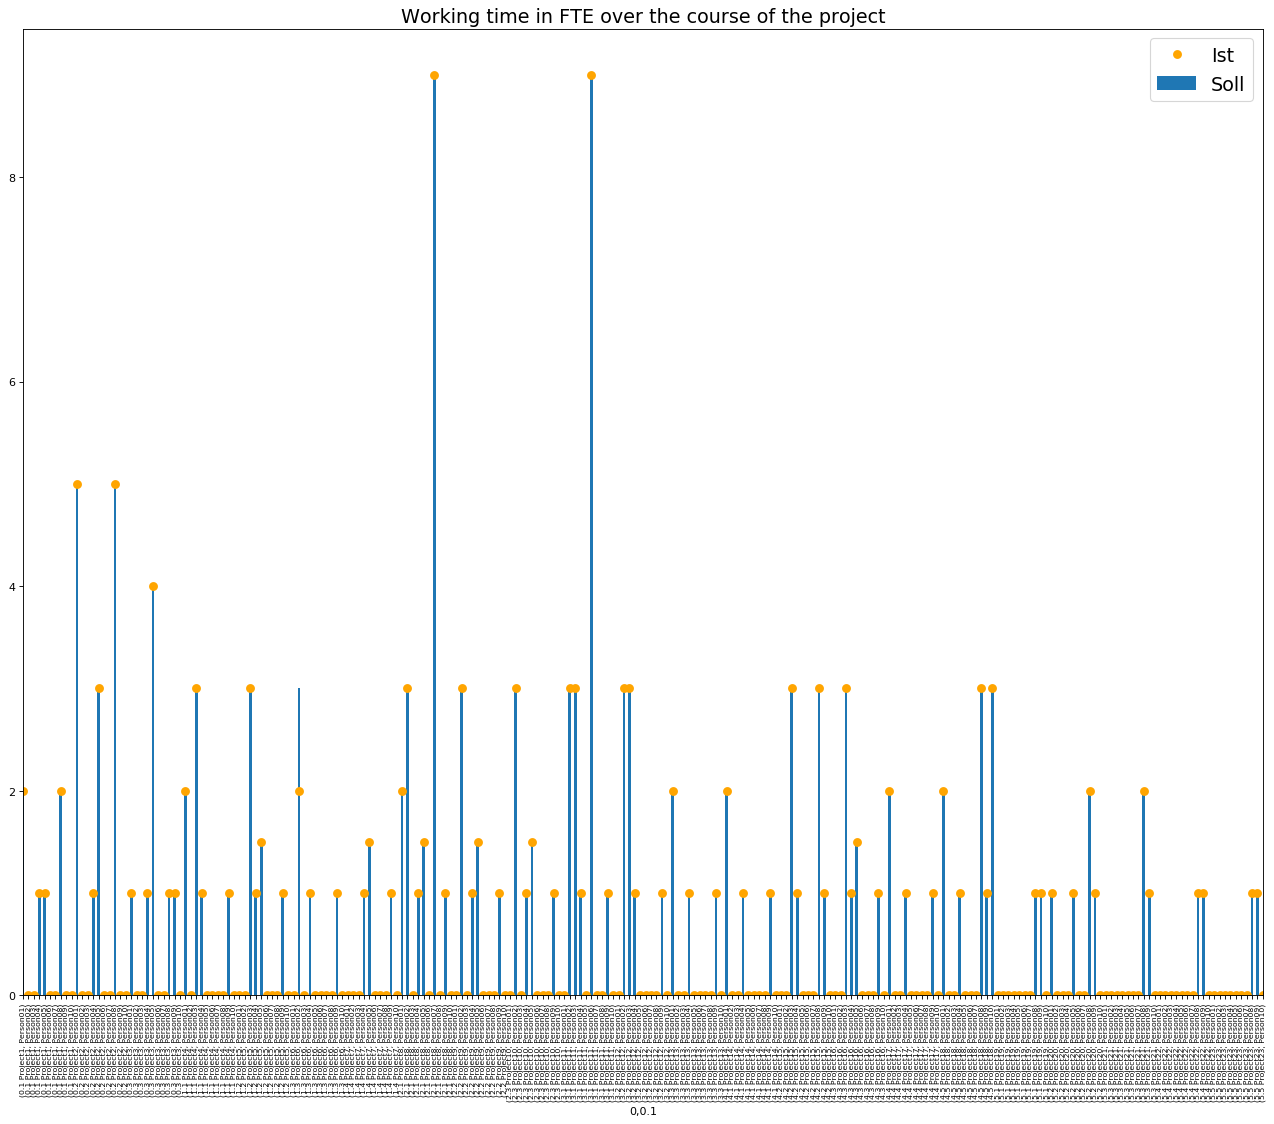

In [40]:
import matplotlib.pyplot as plt

## Working time plot
# The following plot compares the difference of FTE allocated pP and project

##### Fixed total: summed over months
# Set bigger overallsize
fig=plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')

# Plot data
workingTime.Soll.plot(kind = 'bar', label = 'Soll')
workingTime.Ist.plot(style = '.', color = 'orange', markeredgewidth = 5, label = 'Ist') # wider orange dot


# Formal parameters
plt.legend(loc='upper right', fontsize = 'xx-large')
plt.xticks(rotation='vertical', fontsize = 'x-small')
plt.title('Working time in FTE over the course of the project', fontsize = 'xx-large')

plt.show()

In [41]:
# Capacity diagnosis: some people don't work up to their capacity. FixedTotal would have to change in order to 
# make the problem feasible.
capIst.loc[:,['Ist', 'Soll']]

,Ist,Soll
0.1,,
Person01,21.0,21.0
Person02,17.0,18.0
Person03,18.0,18.0
Person04,18.0,18.0
Person05,18.0,18.0
Person06,9.0,9.0
Person07,9.0,9.0
Person08,21.0,21.0
Person09,21.0,21.0


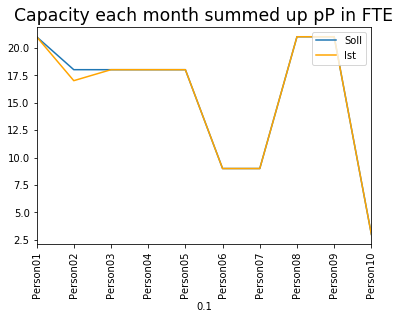

In [42]:
## Capacity plot
# Plot of capacity available vs. allocated by model. The difference result from our soft constraint zcap above.
capIst.Soll.plot(label = 'Soll')
capIst.Ist.plot(color = 'orange', label = 'Ist')

plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.title(('Capacity each month summed up pP in FTE'), fontsize = 'xx-large')
plt.show()

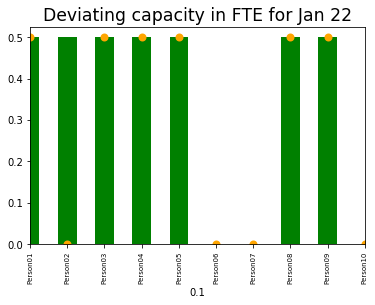

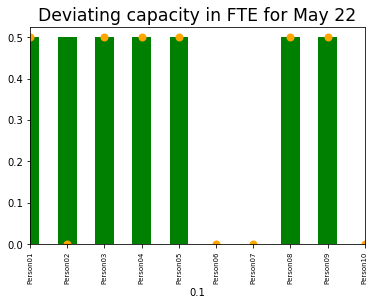

In [43]:
### Capcacity problem plots
# The following plots plot the problematic months.

# slice for 42 months, without the last two columns "ist" and "soll" in capIst
capIstPlot = capIst.iloc[:,0:cap.shape[1]]
#capPlot = np.transpose(cap)


for col in zetcap.columns:
    if (any(zetcap.loc[:,col] != 0)): # if any of the soft constraints for that month is non-null
        
        # Plot data
        ax = cap.loc[:,col].plot(kind = 'bar', color = "green", label = 'Soll')
        capIstPlot.loc[:,col].plot(style = '.', color = 'orange', markeredgewidth = 5, label = 'Ist',
                                       ax = ax) # wider orange dot


        # Formal parameters
        plt.xticks(rotation='vertical', fontsize = 'x-small')
        plt.title('Deviating capacity in FTE for {}'.format(col), fontsize = 'xx-large')

        plt.show()

The deviating capacity mainly comes from two columns don't meet the capacity. Diagnosis: they were assigned too many hours in comparison to their time being.  
  
The model overall performs well with only a few deviations from the desired capacity.